#### Human activity classification with convolutional encoder feature representations

The model architecture and feature engineering methods from the following paper are implemented

[On the Role of Features in HAR](https://dl.acm.org/doi/10.1145/3341163.3347727)

Classification: probabilistic classification with MLP

In [37]:
import torch
import numpy as np
import os
import pandas as pd
import json
import sys

import torch
import torch.nn.functional as F

from skopt import gp_minimize
from skopt.space import Integer, Real
import matplotlib.pyplot as plt

from skopt.plots import plot_convergence
from skopt.plots import plot_gaussian_process
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [41]:
a = F.one_hot(torch.tensor(3), 5)
b = F.one_hot(torch.tensor(1), 5)
a, b

(tensor([0, 0, 0, 1, 0]), tensor([0, 1, 0, 0, 0]))

In [42]:
torch.argmax(a)

tensor(3)

In [36]:
s = pd.Series([1, 2, 3, 4, 5, 6,7])
x = s[-12:].values**2
y = np.arange(len(x))
grad = np.gradient(y, x)

grad

array([0.33333333, 0.28333333, 0.17619048, 0.12896825, 0.1020202 ,
       0.08449883, 0.07692308])

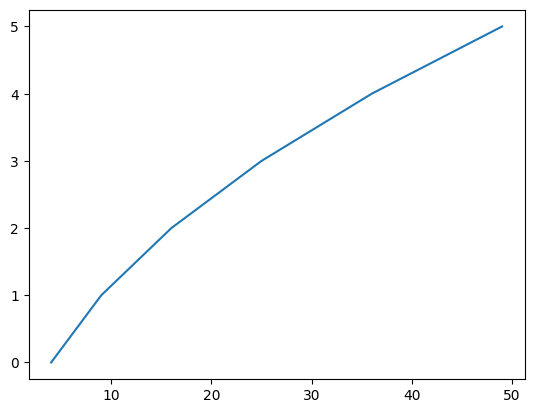

In [31]:
plt.plot(x, y)

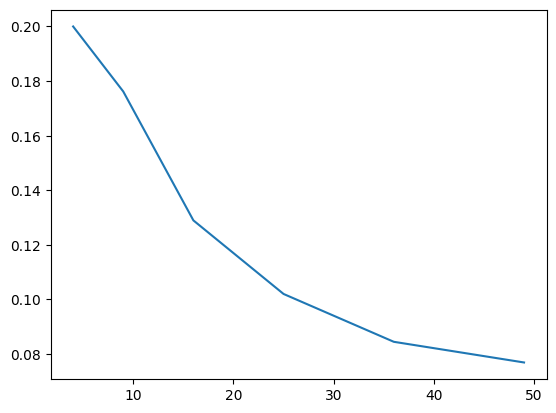

In [33]:
plt.plot(x, grad)

In [ ]:
param_space = [
    Integer(16,  128, name='hidden_dim'), # hidden layer dimension
]

# run different configs
configs = [
    {'latent_dim': 128, 'conv_blocks': [1, 32], 'kernel': (3, 2), 'id': 'Mini'}
]

save_filepath = "..\\saved_models\\classifier\\"
training_epochs = 1

for config in configs:
    train_and_save_conv_ae(config=config, num_epochs=training_epochs, save_filepath=save_filepath)

In [2]:
import sys
module_dir = "../modules"
if module_dir not in sys.path:
    sys.path.append(module_dir)
    
from frame_dataloader_heavy import WorkloadFrame
from convolutional_autoencoder import ConvAE
import utils

#### Cognitive/Physical workload Dataset

Input: consists of individual frames of length context_length * signal_length


#### Classification head

Train classification head on encoded feature representations, backpropagate through encoder aswell

In [ ]:
with open(model_filepath+model_name+'.json', 'r') as file:
    meta_data = json.load(file)
print(meta_data)

{'model name': 'conv_ae_6253059', 'learning rate': 0.001, 'optimizer': 'Adam', 'latent dim': 2084, 'channel sizes': [1, 64, 128, 256, 512], 'kernel size': [3, 3]}


In [ ]:
# load pretrained conv_ae

conv_ae_2 = ConvAE2d()
conv_ae_2.load_state_dict(torch.load('path_to_model/conv_ae.pth'))
conv_ae_2.eval()

# freeze all layers
for param in conv_ae.parameters():
    param.requires_grad = False  

# change last fc layers
num_features = conv_ae_2.fc.in_features
conv_ae_2.fc = nn.Linear(num_features, new_num_classes)

# Move to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
conv_ae_2.to(device)

# Define optimizer and loss function
optimizer = torch.optim.Adam(conv_ae_2.fc.parameters(), lr=1e-3)  # only train last layer
criterion = nn.CrossEntropyLoss()


#### Classification Training Loop

#### Classification model parameters